# QC and processing raw barcode counts for Library 1 with the Rho promoter
This notebook takes raw barcode counts and processes it into activity scores for each replicate. Then, we do statistics to determine which sequences are significantly different from the Rho promoter alone. There are three biological replicates of RNA and one DNA sample from the input plasmid pool.

In [1]:
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats

sys.path.insert(0, "utils")
from utils import modeling, plot_utils, quality_control

In [2]:
plot_utils.set_manuscript_params()

## Load in data

In [3]:
# File names
barcode_count_dir = os.path.join(os.getcwd(), "Data", "Rhodopsin")
barcode_count_files = ["library1Plasmid.counts", "library1Rna1.counts",
                      "library1Rna2.counts", "library1Rna3.counts"]
barcode_count_files = [os.path.join(barcode_count_dir, i) for i in barcode_count_files]

# Stuff for downstream functions
sample_labels = np.array(["DNA", "RNA1", "RNA2", "RNA3"])
sample_rna_mask = np.array([False, True, True, True])
rna_labels = sample_labels[sample_rna_mask]
dna_labels = sample_labels[np.logical_not(sample_rna_mask)]
n_samples = len(sample_labels)
n_rna_samples = len(rna_labels)
n_dna_samples = len(dna_labels)

n_barcodes_per_sequence = 3
results_dir = barcode_count_dir
output_prefix = os.path.join(results_dir, "library1")

all_sample_counts_df = quality_control.read_bc_count_files(barcode_count_files, sample_labels)
all_sample_counts_df.to_csv(f"{output_prefix}RawBarcodeCounts.txt", sep="\t", na_rep="NaN")
all_sample_counts_df.head(20)

,label,DNA,RNA1,RNA2,RNA3
barcode,,,,,
AACAACAAG,chr16-87432635-87432799_CPPQ_scrambled,3019,148,325,97
AACAACCGC,chr4-119112319-119112483_CPPE_WT,4117,24493,25950,23406
AACAACGGG,chr7-128854234-128854398_UPCE_WT,86,76,39,233
AACAACTAC,chr4-138107597-138107761_UPPE_WT,827,926,857,659
AACAACTGT,chr5-31298508-31298672_CPPE_WT,7170,492,392,149
AACAAGCGG,chr16-37868024-37868188_UPPP_MUT-allCrxSites,1199,98,147,206
AACAAGGAC,chr9-72409911-72410075_CBPE_MUT-shape,909,1920,1107,995
AACAAGGCG,chr8-70212225-70212389_CPPP_MUT-allCrxSites,98,33,43,19
AACAAGTAG,chr15-72652217-72652381_CPPE_WT,1851,2557,3203,2688


## Threshold barcode counts, assess reproducibility
Set barcodes that are below the DNA cutoff to an NaN (because they are missing from the input plasmid pool) and those that are below any of the RNA cutoffs to zero in all replicates.

Barcodes missing in DNA:
Sample DNA: 1090 barcodes
1090 barcodes are missing from more than 0 DNA samples.
Barcodes off in RNA:
Sample RNA1: 1744 barcodes
Sample RNA2: 1913 barcodes
Sample RNA3: 1491 barcodes
2215 barcodes are off in more than 0 RNA samples.
There are a total of  157.151 million barcode counts.


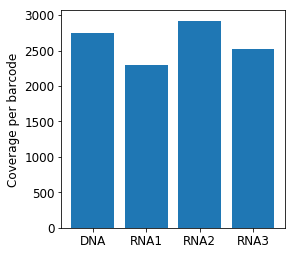

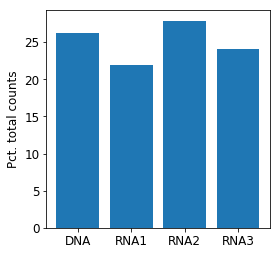

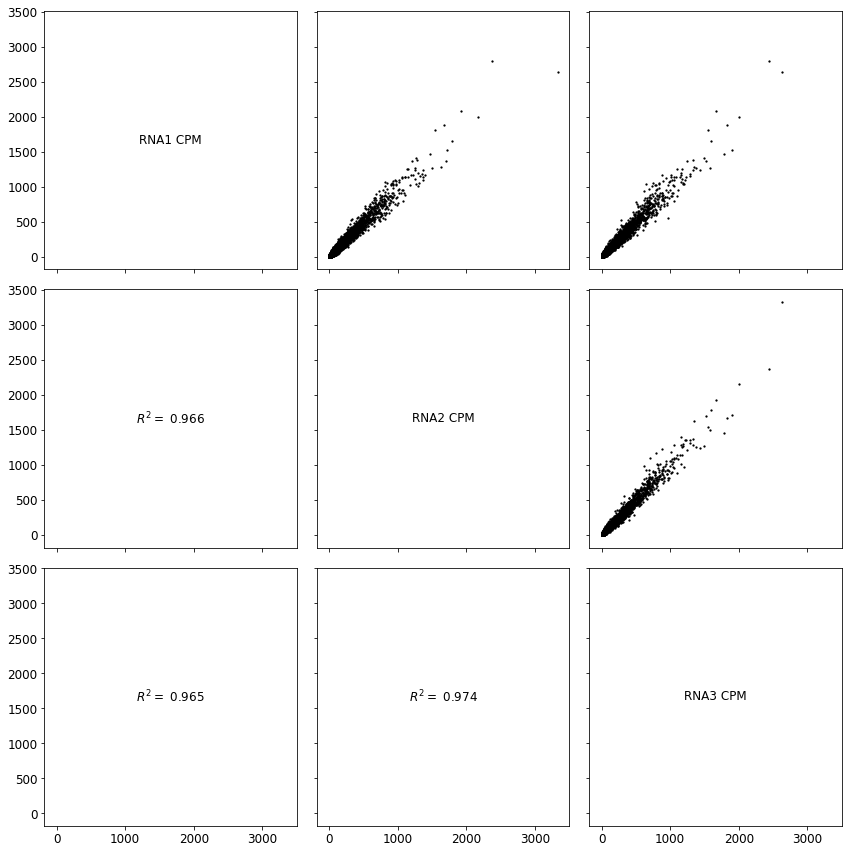

In [4]:
cutoffs = [10, 5, 5, 5]
threshold_sample_counts_df = quality_control.filter_low_counts(all_sample_counts_df, sample_labels, cutoffs,
                                                               dna_labels=dna_labels, bc_per_seq=n_barcodes_per_sequence)
fig = quality_control.reproducibility_plots(threshold_sample_counts_df, rna_labels, "CPM", big_dimensions=True)
plot_utils.save_fig(fig, f"{output_prefix}Reproducibility", timestamp=False)

## Normalize RNA barcode counts by plasmid barcode counts

In [5]:
normalized_sample_counts_df = quality_control.normalize_rna_by_dna(threshold_sample_counts_df, rna_labels, dna_labels)
# Drop DNA
barcode_sample_counts_df = normalized_sample_counts_df.drop(columns=dna_labels)

## Compute expression across replicates

In [6]:
activity_replicate_df = quality_control.average_barcodes(barcode_sample_counts_df)
activity_replicate_df.to_csv(f"{output_prefix}ReplicateExpression.txt", sep="\t", na_rep="NaN")

## Normalize to basal, average across replicates, do statistics

In [7]:
sequence_expression_df = quality_control.basal_normalize(activity_replicate_df, "BASAL")
# Compare vs. basal
sequence_expression_df["expression_pvalue"] = quality_control.log_ttest_vs_basal(activity_replicate_df, "BASAL")
sequence_expression_df["expression_qvalue"] = modeling.fdr(sequence_expression_df["expression_pvalue"])

# Save to file
sequence_expression_df.to_csv(f"{output_prefix}TotalExpressionSummary.txt", sep="\t", na_rep="NaN")

/home/ryan/Documents/DBBS/CohenLab/Manuscripts/CRX-Information-Content/utils/quality_control.py:408: RuntimeWarning: invalid value encountered in double_scalars
  cov = std / mean
